100%|██████████| 212521/212521 [00:28<00:00, 7396.32it/s]


Execution: 28.738398790359497 seconds


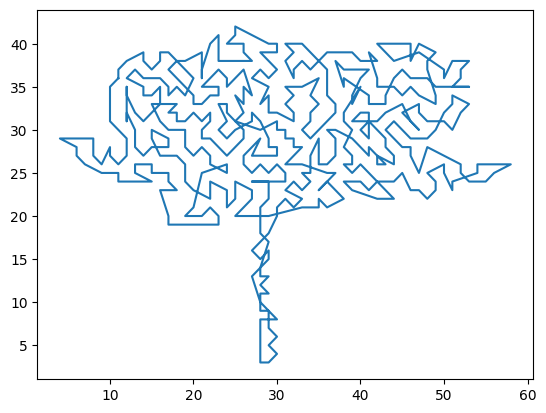

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy
import random
from tqdm import tqdm
import time


class DitheringMaker:
    '''
    Performs dithering on an image using the classical Floyd-Steinberg dithering algorithm. The
    dithering isn't applied to the last row or the edge columns. Instead, the last row and edge
    columns are made all white as this will later not add any vertices when we extract vertices
    from the dithering.

    Members
    -------
    dithering : Numpy array of Int of Shape(n_rows, nCol)
        The array holding the dithering of the image. Note that the last row and edge columns will
        always be converted to white (i.e. 255).

    row_disp : Numpy array of Int of shape (2, 3)
        The row offsets to apply the diffusions to.

    col_disp : Numpy array of Int of shape (2, 3)
        The column offsets to apply the diffusions to.

    diffusion_prop : Numpy array of Float of shape (2, 3)
        The Floyd-Steinberg coefficients for diffusing the error in the
        dithering.
    '''

    def __init__(self):
        '''
        Initialize the dithering to None as we haven't performed any yet.

        The displacement of indices and the diffusion coefficients are for the classic
        Floyd-Steinberg dithering algorithm.
        '''

        self.dithering = None

        self.row_disp = np.full((2, 3), np.arange(0, 2)[:, np.newaxis], dtype = 'int')
        self.col_disp = np.full((2, 3), np.arange(-1, 2), dtype = 'int')
        self.diffusion_prop = np.array([[0, 0, 7],
                                        [3, 5, 1]]) / 16

    def make_dithering(self, pixels, cutoff = 255 / 2):
        '''
        Apply the classic Floyd-Steinberg dithering algorithm, but for simplicity
        we just make the edge columns and the last row all white (which will give
        us no vertices when we later extract vertices).

        Parameters
        ----------
        pixels : Numpy array of Int of shape (n_rows, n_cols)
            The gray scale pixels to apply the dithering to.

        cutoff : Float
            The cut off for making a dithering pixel either 0 or 255.

        Returns
        -------
        Numpy array of Int of Shape (n_rows, n_cols)
            The final dithering; each pixel is either 0 or 255 (black or white).
        '''

        # We use Floyd-Steinberg dithering. Error diffusion is
        # _     x     7/16
        # 3/16  5/16  1/16

        self.dithering = pixels.copy().astype('float')

        n_rows, n_cols = pixels.shape

        # Initialize the first column to be white.

        self.dithering[:][0] = 255

        # Iterate over each row, applying the dithering and diffusing the error.

        for row in range(n_rows - 1):
            for col in range(1, n_cols - 1):

                dither, error = self.get_dither(row, col, cutoff)
                self.dithering[row, col] = dither
                self.diffuse_error(error, row, col)

        # Make the last column and the last row all white.

        self.dithering[:, -1] = 255
        self.dithering[-1, :] = 255

        # Convert dithering to Numpy array of Int.

        self.dithering = self.dithering.astype('int')

        return self.dithering

    def get_dither(self, row, col, cutoff):
        '''
        Turn (dithered) pixel into either 0 or 255 using cutoff.

        Parameters
        ----------
        row : Int
            Index of pixel row.

        col : Int
            Index of pixel column.

        cutoff : Float
            The cutoff value to use for converting dithering value to either 0 or 255
            (black or white).

        Returns
        -------
        dither : Float
            Floating point value that is either 0.0 or 255.0 (black or white).

        error : Float
            The error in applying the conversion, this needs to be diffused to other pixels
            according to the dithering algorithm.
        '''

        pixel = self.dithering[row][col]

        if pixel < cutoff:
            dither = 0.0
        else:
            dither = 255.0

        error = pixel - dither

        return dither, error

    def diffuse_error(self, error, row, col):
        '''
        Diffuse the error from a (dithered) pixel conversion to black or white. The diffusion
        is applied to the neighbors of the pixel at position [row, col] according to the
        Floyd-Steinberg algorithm.

        Parameters
        ----------
        error : Float
            The size of error to diffuse to other pixels.

        row : Int
            The row index of where the conversion took place.

        col : Int
            The column index of where the conversion took place.
        '''

        self.dithering[row + self.row_disp, col + self.col_disp] += error * self.diffusion_prop


def get_vertices(dithering):
    '''
    Get the vertices from a black and white image, not grayscale (in particular a dithered image).
    Every black pixel (value 0.0) gives a vertex.

    Parameters
    ----------
    dithering : Numpy array of shape (n_rows, n_cols)
        The array of pixels for the dithered image.

    Returns
    -------
    Numpy array of shape (nVertices, 2)
        The xy-coordinates of the vertices.
    '''

    n_rows, n_cols = dithering.shape

    # Each black pixel gives a vertex.
    keep_pixel_mask = (dithering == 0)

    # Get the row and column indices of the vertices.

    rows = np.full(dithering.shape, np.arange(n_rows)[:, np.newaxis]).reshape(-1)
    cols = np.full(dithering.shape, np.arange(n_cols)).reshape(-1)

    rows = rows[keep_pixel_mask.reshape(-1)]
    cols = cols[keep_pixel_mask.reshape(-1)]

    # Get the xy-coordinate of the vertices. Make sure to transform row index so
    # that the last row has y value 0.

    vertices = np.stack([cols, n_rows - rows], axis = -1)

    return vertices


def getPixels(image, ds=1):
    '''
    Get the pixels as a numpy array from a PIL image.
    We can take the mean of each ds x ds subsquare as an array element inorder to down-size
    the size of the image if we want to.

    Parameters
    ----------
    image : PIL Image
        The PIL image to convert.

    ds : Int
        We take the mean of each ds x ds sub-square for a single element of our array.

    Returns
    -------
    2d Numpy array of floats
        The converted values of the pixels in the image. We use mean because we
        possibly took a mean over sub-squares.
    '''

    imwidth, imheight = image.size
    pixels = list(image.getdata())
    pixels = np.array(pixels).reshape((imheight, imwidth))

    pixels = [[pixels[i:i + ds, j:j + ds].mean() for j in np.arange(0, imwidth, ds)]
              for i in np.arange(0, imheight, ds)]
    pixels = np.array(pixels)
    return pixels


class SimulatedAnnealing:
    """
    Performs the simulating annealing method, where the step size changes to allow both exploration and exploitation.

    Members
    -------
    dots : 2d Array of floats
        Array of coordinates of dots in dithered image

    distance_matrix: 2d Array of floats
        Array of distances between corresponding dots

    path : Array of Int
        current path found by the algorithm

    current_length : Float
        length of current path

    temperature: Float
        starting temperature of algorithm

    max_iter: Int
        number of iterations performed by the algorithm

    best_path: Array of Int
        Best path found by the algorithm

    best_path_length: Float
        Length of the best path found by the algorithm
    """
    def __init__(self, dots, temperature=None, max_iter=None, greedy=False):
        """
        Initialization of SimulatedAnnealing class. Creates the distance matrix based on dots.
        :param dots: 2d Array of Float
            Coordinates of dots in dithered image
        :param temperature: Float
            Custom temperature value
        :param max_iter: Int
            Custom number of iterations
        """
        self.dots = dots
        self.distance_matrix = [[self.calculate_distance(i, j) for j in range(len(dots))] for i in range(len(dots))]
        self.path = self.greedy_path() if greedy else [i for i in range(len(dots))]
        self.current_length = self.calculate_path_length(self.path)
        self.temperature = self.current_length if not temperature else temperature
        self.max_iter = len(dots) ** 2 if not max_iter else max_iter
        self.best_path = self.path
        self.best_path_length = self.current_length

    def solveTSP(self, verbose=False):
        """
        Main algorithm for Simulated Annealing.
        For number of iterations, tries to place every dot in path differently, to get better solution.
        Decreases the temperature every iteration, unless there is no improvement.
        In that case increases the temperature.
        :param verbose: Bool
            Should the information about iterations and reheating be printed
        :return: Array of Int
            Best path found by the algorithm
        """
        temperature = self.temperature
        change = True
        for i in tqdm(range(self.max_iter)):
            if change:
                temperature = temperature * (1 - 1/len(self.path))
            else:
                temperature = temperature * (1 + 1/self.max_iter)
            if verbose:
                print('Iteration:', i, 'best path:', self.best_path_length, 'current_path', self.current_length)
            to_change_1 = np.random.randint(0, high=len(self.path))
            to_change_2 = np.random.randint(0, high=len(self.path))
            while to_change_1 == to_change_2:
                to_change_2 = np.random.randint(0, high=len(self.path))
            change = self.change_point(to_change_1, to_change_2, temperature)
        return self.best_path

    def change_point(self, i, j, temperature):
        """
        Function to try and change position of dots in path.
        Either reverses segment of path, or swaps positions of input dots with some two consecutive ones.
        :param i: Int
            First dot to be replaced
        :param j: Int
            Second dot to be replaced, usually consecutive in the path
        :param temperature: Double
            Current temperature
        :return: Bool
            Was anything changed in the path
        """
        new_path = copy.copy(self.path)
        if random.random() < 0.5:
            new_path[i] = self.path[j]
            new_path[j] = self.path[i]
        else:
            start = i
            if i == len(self.path) - 1:
                start = j
            end = np.random.randint(start, high=len(self.path))
            new_path[start:end] = reversed(self.path[start:end])
        new_length = self.calculate_path_length(new_path)
        change = new_length - self.current_length
        if change < 0:
            self.path = new_path
            self.current_length = new_length
            if new_length < self.best_path_length:
                self.best_path = new_path
                self.best_path_length = new_length
                return True
        else:
            if change != 0.0 and random.random() < np.exp(-(change / temperature)):
                self.path = new_path
                self.current_length = new_length
                return True
        return False

    def calculate_distance(self, i, j):
        """
        Function to calculate Euclidian distance between dots
        :param i: Int
            Index of first dot
        :param j: Int
            Index of second dot
        :return: FLoat
            Distance between dots
        """
        return ((self.dots[i][0] - self.dots[j][0]) ** 2 + (self.dots[i][1] - self.dots[j][1]) ** 2) ** 0.5

    def calculate_path_length(self, path):
        """
        Function to calculate length of the path
        :param path: Array of Int
            Path
        :return: Float
            Length of the path
        """
        length = self.distance_matrix[path[len(path) - 1]][path[0]]
        for i in range(len(path) - 1):
            length = length + self.distance_matrix[path[i]][path[i + 1]]
        return length

    def plot_path(self, path):
        """
        Function to plot the path
        :param path: Array of Int
            Path
        """
        x = []
        y = []
        for dot in path:
            x.append(self.dots[dot][0])
            y.append(self.dots[dot][1])
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y)
        plt.show()

    def greedy_path(self):
        """
        Function to initialize first path using greedy approach.
        Gets nearest dot not in the path for each dot.
        :return: Array of Int
            Proposed path
        """
        current = 0
        path = [0]
        while len(path) != len(self.dots):
            min_step = max(max(x) for x in self.dots)
            next_step = -1
            for i in range(len(self.dots)):
                if self.distance_matrix[current][i] < min_step and i not in path:
                    min_step = self.distance_matrix[current][i]
                    next_step = i
            path.append(next_step)
            current = next_step
        return path


if __name__ == '__main__':
    # Open the test image
    image = Image.open('flower.png').convert('L')
    # For now the function from the internet to get pixels is used
    pixel_image = getPixels(image, ds=5)
    # For now the function from the internet to make dithering is used
    ditherer = DitheringMaker()
    dithered_image = ditherer.make_dithering(pixel_image)
    vertices = get_vertices(dithered_image)
    # Perform Simulated Annealing on given dots
    annealer = SimulatedAnnealing(vertices)
    start = time.time()
    best_path = annealer.solveTSP()
    # Draw the result
    end = time.time()
    print('Execution:', end-start, 'seconds')
    annealer.plot_path(best_path)
